<a href="https://colab.research.google.com/github/LevWilliams/DigitClassifier/blob/master/DigitIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [2]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 89.4MB/s]
 55% 5.00M/9.16M [00:00<00:00, 36.5MB/s]
100% 9.16M/9.16M [00:00<00:00, 58.4MB/s]
 82% 5.00M/6.09M [00:00<00:00, 37.8MB/s]
100% 6.09M/6.09M [00:00<00:00, 38.9MB/s]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import keras

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [7]:
# Load the data
train = pd.read_csv("train.csv.zip")
test = pd.read_csv("test.csv.zip")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

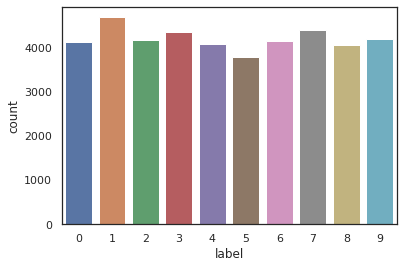

In [8]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [9]:
X_train = X_train / 255.0
test = test / 255.0

Reshaping vects into matricies (images)

In [10]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

May need one-hot-encoding. if necessary, add it here.

In [25]:


# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)



In [26]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

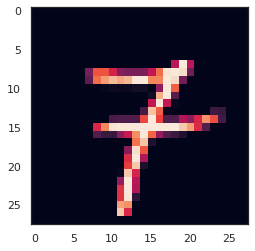

In [27]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [58]:
def create_model():
  model_input = tf.keras.layers.Input(shape = (28,28,1), name = 'img')
  Conv1 = tf.keras.layers.Conv2D(100,kernel_size = (5,5), activation="relu",padding = 'Same')(model_input)
  Pool1  = tf.keras.layers.MaxPool2D(pool_size=(2,2))(Conv1)
  Pool1 = tf.keras.layers.Dropout(0.5)(Pool1)
  Conv2 = tf.keras.layers.Conv2D(100,kernel_size = (3,3),padding = 'Same', activation="relu")(Pool1)
  Pool2  = tf.keras.layers.MaxPool2D(pool_size=(2,2))(Conv2)
  Pool2 = tf.keras.layers.Dropout(0.5)(Pool2)
  Flat = tf.keras.layers.Flatten()(Pool2)
  Dense1 = tf.keras.layers.Dense(units= 100, activation="relu")(Flat)
  Dense1 = tf.keras.layers.Dropout(0.5)(Dense1)
  Dense2 = tf.keras.layers.Dense(units= 100, activation="relu")(Dense1)
  Dense2 = tf.keras.layers.Dropout(0.5)(Dense2)
  Output = tf.keras.layers.Dense(units= 10, activation="softmax")(Dense2)

  model = tf.keras.Model(inputs = model_input,outputs = Output)
  model.build(input_shape = (28,28,1))

  # Define the optimizer
  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

  model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

  model.summary()

  return model

In [59]:
model = create_model()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 100)       2600      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 100)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 100)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 100)       90100     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 100)         0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 7, 100)       

In [54]:


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)



In [55]:


epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86



In [67]:


# Without data augmentation
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,validation_data = (X_val, Y_val))



Without data aug the validation accuracy reaches about .985 - .986

In [56]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [60]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, callbacks=[learning_rate_reduction])

Epoch 1/30
396/396 - 125s - loss: 0.9951 - accuracy: 0.6628 - val_loss: 0.1251 - val_accuracy: 0.9651
Epoch 2/30
396/396 - 125s - loss: 0.3879 - accuracy: 0.8861 - val_loss: 0.0775 - val_accuracy: 0.9765
Epoch 3/30
396/396 - 124s - loss: 0.2974 - accuracy: 0.9179 - val_loss: 0.0734 - val_accuracy: 0.9786
Epoch 4/30
396/396 - 126s - loss: 0.2458 - accuracy: 0.9326 - val_loss: 0.0510 - val_accuracy: 0.9870
Epoch 5/30
396/396 - 123s - loss: 0.2250 - accuracy: 0.9392 - val_loss: 0.0485 - val_accuracy: 0.9857
Epoch 6/30
396/396 - 124s - loss: 0.2200 - accuracy: 0.9422 - val_loss: 0.0462 - val_accuracy: 0.9889
Epoch 7/30
396/396 - 124s - loss: 0.2089 - accuracy: 0.9449 - val_loss: 0.0360 - val_accuracy: 0.9905
Epoch 8/30
396/396 - 124s - loss: 0.2160 - accuracy: 0.9454 - val_loss: 0.0388 - val_accuracy: 0.9881
Epoch 9/30
396/396 - 126s - loss: 0.2090 - accuracy: 0.9473 - val_loss: 0.0380 - val_accuracy: 0.9894
Epoch 10/30

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000

In [62]:


# Plot the loss and accuracy curves for training and validation 
#fig, ax = plt.subplots(2,1)
#ax[0].plot(history.history['loss'], color='b', label="Training loss")
#ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
#legend = ax[0].legend(loc='best', shadow=True)

#ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
#ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
#legend = ax[1].legend(loc='best', shadow=True)



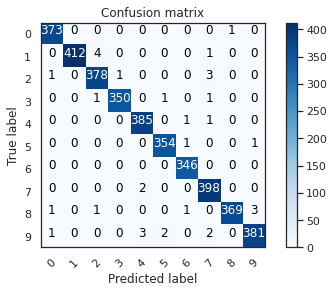

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

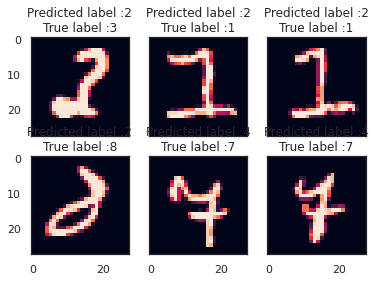

In [64]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [65]:


# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")



In [66]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("LevMNISTSubmission.csv",index=False)